In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize


print(os.listdir("C:/Users/20115/Desktop/Dataset/"))
print(os.listdir("C:/Users/20115/Desktop/Dataset/train"))
TRAIN_DIR = "C:/Users/20115/Desktop/Dataset/train/"
TEST_DIR =  "C:/Users/20115/Desktop/Dataset/validation/"

def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['Sick']:
                label = 1
            else:
                label = 2
    return nextdir, label
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['Sick']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

X_train, y_train = get_data(TRAIN_DIR)
X_test , y_test = get_data(TEST_DIR)
print(X_train.shape,'\n',X_test.shape)
print(y_train.shape,'\n',y_test.shape)


    

  0%|          | 0/318 [00:00<?, ?it/s]

['train', 'validation']
['NORMAL', 'Sick']


100%|██████████| 58/58 [00:40<00:00,  1.42it/s]

(636, 150, 150, 3) 
 (116, 150, 150, 3)
(636,) 
 (116,)


In [3]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [4]:
print(y_train.shape,'\n',y_test.shape)


(636, 2) 
 (116, 2)


In [5]:
Pimages = os.listdir(TRAIN_DIR + "Sick")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")





(Left) - No Covid Vs (Right) - Covid
-----------------------------------------------------------------------------------------------------------------------------------


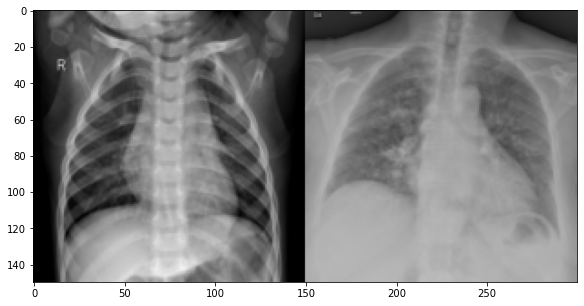

(Left) - No Covid Vs (Right) - Covid
-----------------------------------------------------------------------------------------------------------------------------------


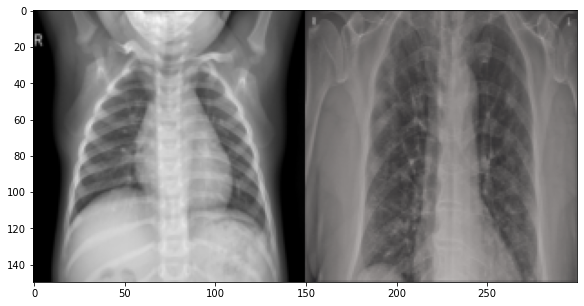

(Left) - No Covid Vs (Right) - Covid
-----------------------------------------------------------------------------------------------------------------------------------


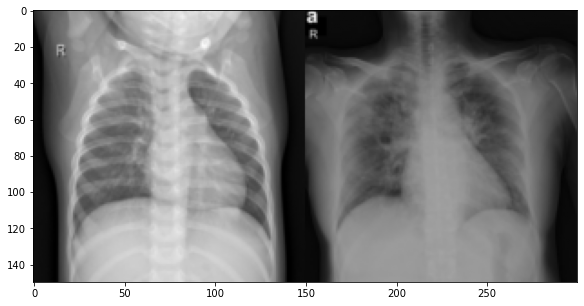

(Left) - No Covid Vs (Right) - Covid
-----------------------------------------------------------------------------------------------------------------------------------


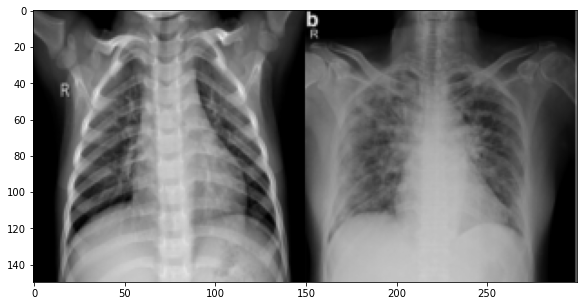

In [6]:
from matplotlib import pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"Sick/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Covid Vs (Right) - Covid")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(1,5):
    plotter(i)


In [7]:

from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)


In [8]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD , RMSprop
from tensorflow.keras.layers import Conv2D , BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import backend as K

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [21]:

def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_3/MaxPool' (op: 'MaxPool') with input shapes: [?,1,75,32].